In [ ]:
!pip install awpy
!pip install --force-reinstall "numpy[all]>=1.26.0,<2.2.0"
!pip install torch_geometric

In [2]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")

from awpy import Demo
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split

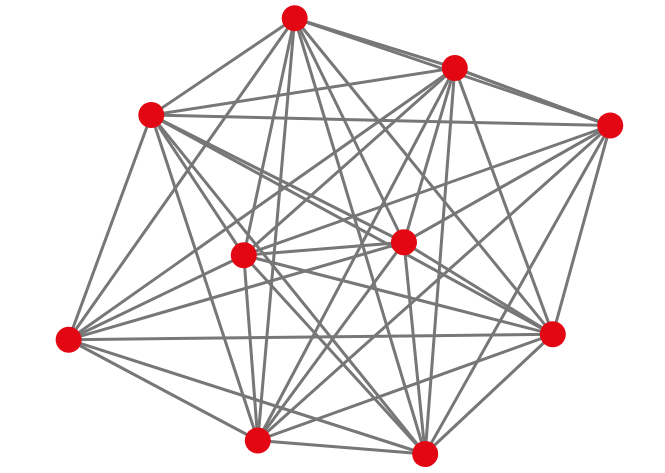

In [37]:
files = os.listdir('games')
df = pd.DataFrame()
list_dfs = []
for i, file in enumerate(files):
    try:
        dem = Demo(f"games/{file}", verbose=True,tickrate=128)
    
        dem.parse(player_props=["X","Y","Z","health","inventory","has_helmet","has_defuser","side","current_equip_value","round_start_equip_value","armor_value","score","is_bomb_planted","is_alive","team_num","is_defusing","in_bomb_zone"])
        df_temp = dem.ticks.to_pandas()
        df_temp = df_temp.loc[df_temp["tick"]%128 == 0]
        df_temp['game_num'] = i
        round_winner = dem.rounds['winner'].to_pandas()
        round_winner = (round_winner.values == 'ct').astype(int)
        df_temp['winner'] = df_temp['round_num'].apply(lambda x: round_winner[x - 1] if x - 1 < len(round_winner) else np.nan)
        list_dfs.append(df_temp)

    except Exception as e:
       print(e) 
       break
df = pd.concat(list_dfs, ignore_index=True)


2025-06-08 22:46:29.749 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/chinggis-warriors-vs-fluxo-m2-mirage.dem
2025-06-08 22:46:45.973 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/chinggis-warriors-vs-fluxo-m2-mirage.dem, took 16.22 seconds
2025-06-08 22:46:46.924 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/faze-vs-bcgame-m1-mirage.dem
2025-06-08 22:47:02.957 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/faze-vs-bcgame-m1-mirage.dem, took 16.03 seconds
2025-06-08 22:47:04.028 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/betboom-vs-flyquest-mirage.dem
2025-06-08 22:47:19.085 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/betboom-vs-flyquest-mirage.dem, took 15.06 seconds
2025-06-08 22:47:21.666 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/faze-vs-heroic-m3-mirage.dem
2025-06-08 22:47:43.979 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/faze-vs-heroic-m3-mirage.dem, took 22.31 seconds


In [38]:
"""
    High Explosive Grenade - he,
    Smoke Grenade - smoke,
    Molotov - molotov,
    Incendiary Grenade - incendiary,
    Decoy Grenade - decoy,
    Flashbang - flash
"""

df['he'] = df['inventory'].apply(lambda x: 1 if 'High Explosive Grenade' in x else 0)
df['smoke'] = df['inventory'].apply(lambda x: 1 if 'Smoke Grenade' in x else 0)
df['molotov'] = df['inventory'].apply(lambda x: 1 if 'Smoke Molotov' in x else 0)
df['incendiary'] = df['inventory'].apply(lambda x: 1 if 'Incendiary Grenade' in x else 0)
df['flash'] = df['inventory'].apply(lambda x: 1 if 'Flashbang' in x else 0)
df['decoy'] = df['inventory'].apply(lambda x: 1 if 'Decoy Grenade' in x else 0)
df.drop(columns=['inventory'],inplace=True)
df

,is_bomb_planted,score,health,team_num,has_defuser,has_helmet,place,in_bomb_zone,is_defusing,armor,...,name,round_num,game_num,winner,he,smoke,molotov,incendiary,flash,decoy
0,False,0,100.0,2.0,False,False,TSpawn,False,False,0.0,...,zevy,1,0,1,0,0,0,0,0,0
1,False,0,100.0,3.0,False,False,CTSpawn,False,False,0.0,...,ROUX,1,0,1,0,0,0,0,0,0
2,False,0,100.0,2.0,False,False,TSpawn,False,False,100.0,...,arT,1,0,1,0,0,0,0,0,0
3,False,0,100.0,3.0,False,False,CTSpawn,False,False,100.0,...,controlez,1,0,1,0,0,0,0,0,0
4,False,0,100.0,2.0,False,False,TSpawn,False,False,0.0,...,mlhzin,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66975,False,50,0.0,3.0,False,False,CTSpawn,False,False,0.0,...,Wicadia,22,4,1,0,0,0,0,0,0
66976,False,28,0.0,3.0,False,False,SnipersNest,False,False,0.0,...,woxic,22,4,1,0,0,0,0,0,0
66977,False,46,99.0,3.0,True,True,PalaceInterior,False,False,85.0,...,XANTARES,22,4,1,1,0,0,1,0,0
66978,False,37,0.0,2.0,False,False,BombsiteA,False,False,0.0,...,LNZ,22,4,1,0,0,0,0,0,0


In [41]:

ct_spawn = np.array([-1516.3, -1335.9, -259.97])   # CT Spawn
t_spawn  = np.array([1414.7,    27.6,  -167.97])   # T Spawn
site_a   = np.array([-580.9,  -2159.5, -179.97])   # Bombsite A
site_b   = np.array([-1700.0,   500.0, -230.0])    # Bombsite B 
graph_data_list = []

for game_num in range(len(os.listdir("games"))):
    temp_df = df.loc[df['game_num'] == game_num]
    players = sorted(temp_df.steamid.unique())
    for i,tick in enumerate(sorted(temp_df.tick.unique())):
        state = df.loc[(df['tick']==tick) & (df['game_num'] == game_num)].set_index('steamid').loc[players]
        node_features = []
        try:
            for _, row in state.iterrows():
                pos = np.array([row['X'], row['Y'], row['Z']])
                dist_a = np.linalg.norm(pos - site_a)
                dist_b = np.linalg.norm(pos - site_b)
                try:
                    feats = [
                        row['X'], row['Y'], row['Z'],
                        row['health'], row['armor'],
                        row['current_equip_value'], row['round_start_equip_value'],
                        row['he'], row['smoke'],row['flash'],row['molotov'],row['incendiary'],row['decoy'],
                        dist_a, dist_b,
                        int(row['in_bomb_zone']),
                        int(row['is_alive']),
                        int(row['has_helmet']),
                        int(row['has_defuser']),
                        1 if row['side'] == 'CT' else 0
                    ]
                except Exception as e:
                    print(f'Tick {tick}, from game {game_num} invalid')
                    raise e
                node_features.append(feats)
        except Exception as e:
            print(e)
            continue

        x = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor([[i, j] for i in range(10) for j in range(10)], dtype=torch.long).t().contiguous()
        y = torch.tensor(state['winner'].iloc[0], dtype=torch.float)

        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graph_data.num_nodes = x.shape[0]
        graph_data_list.append(graph_data)

print("Total Graphs: ", len(graph_data_list))
print("Players per Graph: ", 10)
print("Node Feature Size: ", x.shape[1])
print("y por grafo:", y.shape, y)

Tick 53504, from game 1 invalid
int() argument must be a string, a bytes-like object or a real number, not 'NoneType'
Tick 53632, from game 1 invalid
int() argument must be a string, a bytes-like object or a real number, not 'NoneType'
Total Graphs:  6696
Players per Graph:  10
Node Feature Size:  20
y por grafo: torch.Size([]) tensor(1.)


In [42]:
train_val_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
train_graphs, val_graphs = train_test_split(train_val_graphs, test_size=0.125, random_state=42)

In [43]:
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

In [44]:


class CSGOGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=1)
        self.gat2 = GATConv(hidden_channels, out_channels, heads=1)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)


In [45]:
model = CSGOGAT(in_channels=20, hidden_channels=16, out_channels=30)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [46]:
from sklearn.metrics import roc_auc_score

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch).view(-1)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            out = model(batch).view(-1)
            loss = criterion(out, batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(out)
            all_preds.extend(probs.tolist())
            all_labels.extend(batch.y.tolist())
            break
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), auc


In [51]:
results = []
for epoch in range(1, 100):
    train_loss = train()
    val_loss, val_auc = evaluate(val_loader)
    test_loss, test_auc = evaluate(test_loader)
    results.append((epoch, train_loss, val_loss, val_auc))

results_df = pd.DataFrame(results, columns=["Epoch", "Train Loss", "Val Loss", "Val AUC"])
results_df.loc[len(results_df)] = ["TEST", None, test_loss, test_auc]


In [52]:
results_df

,Epoch,Train Loss,Val Loss,Val AUC
0,1,0.532448,0.025275,0.805195
1,2,0.537346,0.027252,0.779221
2,3,0.544948,0.024499,0.805195
3,4,0.528165,0.027976,0.696970
4,5,0.523318,0.023458,0.813853
...,...,...,...,...
95,96,0.491873,0.024920,0.852814
96,97,0.482216,0.029295,0.805195
97,98,0.500637,0.028864,0.714286
98,99,0.488776,0.030241,0.774892


In [47]:
import numpy as np
labels = [g.y.item() for g in graph_data_list]
print("CT win rate:", np.mean(labels))


CT win rate: 0.44489247311827956
